In [ ]:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.spatial.distance import cdist
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Download dataset
print("="*80)
print("CRIME DATA CLUSTERING ANALYSIS")
print("Comparing K-Means vs DBSCAN")
print("="*80)

path = kagglehub.dataset_download("shubhamgupta012/crime-data-from-2020-to-present")
print(f"\nDataset path: {path}")

CRIME DATA CLUSTERING ANALYSIS
Comparing K-Means vs DBSCAN


100%|██████████| 36.5M/36.5M [00:00<00:00, 257MB/s]

Extracting files...



Dataset path: /root/.cache/kagglehub/datasets/shubhamgupta012/crime-data-from-2020-to-present/versions/1


In [ ]:
# Load data
import os
files = os.listdir(path)
csv_file = [f for f in files if f.endswith('.csv')][0]
df = pd.read_csv(os.path.join(path, csv_file))

print(f"Original dataset shape: {df.shape}")


Original dataset shape: (743817, 28)


In [ ]:
# DATA CLEANING & PREPROCESSING
# ============================================================================
print("\n" + "="*80)
print("DATA PREPROCESSING")
print("="*80)

df_clean = df.copy()

# Remove duplicates
df_clean = df_clean.drop_duplicates()
print(f"\nAfter removing duplicates: {df_clean.shape}")

# Drop columns with >50% missing
threshold = len(df_clean) * 0.5
df_clean = df_clean.dropna(thresh=threshold, axis=1)

# Fill missing values
for col in df_clean.columns:
    if df_clean[col].isnull().sum() > 0:
        if df_clean[col].dtype in ['int64', 'float64']:
            df_clean[col].fillna(df_clean[col].median(), inplace=True)
        else:
            df_clean[col].fillna(df_clean[col].mode()[0], inplace=True)

# Convert datetime columns
date_columns = [col for col in df_clean.columns if 'date' in col.lower() or 'time' in col.lower()]
datetime_col = None
for col in date_columns:
    try:
        df_clean[col] = pd.to_datetime(df_clean[col], errors='coerce')
        if datetime_col is None:
            datetime_col = col
    except:
        pass


DATA PREPROCESSING

After removing duplicates: (743817, 28)


In [ ]:
# Extract temporal features if datetime exists
if datetime_col:
    print(f"\nExtracting temporal features from: {datetime_col}")
    df_clean['year'] = df_clean[datetime_col].dt.year
    df_clean['month'] = df_clean[datetime_col].dt.month
    df_clean['day'] = df_clean[datetime_col].dt.day
    df_clean['hour'] = df_clean[datetime_col].dt.hour
    df_clean['dayofweek'] = df_clean[datetime_col].dt.dayofweek
    df_clean['is_weekend'] = (df_clean['dayofweek'] >= 5).astype(int)
    df_clean['quarter'] = df_clean[datetime_col].dt.quarter

print(f"Cleaned dataset shape: {df_clean.shape}")

# Sample data for faster clustering (if dataset is large)
if len(df_clean) > 50000:
    print(f"\nSampling 50,000 records for efficient clustering...")
    df_sample = df_clean.sample(n=50000, random_state=42)
else:
    df_sample = df_clean.copy()

print(f"Working with {len(df_sample)} records")


Extracting temporal features from: Date Rptd
Cleaned dataset shape: (743817, 29)

Sampling 50,000 records for efficient clustering...
Working with 50000 records


In [ ]:
# FEATURE ENGINEERING FOR CLUSTERING
# ============================================================================
print("\n" + "="*80)
print("FEATURE ENGINEERING")
print("="*80)

# Identify feature columns
numeric_cols = df_sample.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df_sample.select_dtypes(include=['object']).columns.tolist()

print(f"\nNumeric features: {len(numeric_cols)}")
print(f"Categorical features: {len(categorical_cols)}")

# Create feature matrix
X_features = df_sample.copy()

# Encode categorical variables
le_dict = {}
for col in categorical_cols:
    if df_sample[col].nunique() < 100:  # Only encode if reasonable number of categories
        le = LabelEncoder()
        X_features[col] = le.fit_transform(df_sample[col].astype(str))
        le_dict[col] = le
    else:
        X_features = X_features.drop(col, axis=1)

# Drop datetime columns
for col in X_features.columns:
    if pd.api.types.is_datetime64_any_dtype(X_features[col]):
        X_features = X_features.drop(col, axis=1)

# Handle any remaining non-numeric
X_features = X_features.select_dtypes(include=[np.number])

print(f"\nFinal feature matrix shape: {X_features.shape}")
print(f"Features used: {X_features.shape[1]}")

# Scale features (crucial for clustering!)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_features)

print("\nFeatures scaled using StandardScaler")




FEATURE ENGINEERING

Numeric features: 17
Categorical features: 9

Final feature matrix shape: (50000, 22)
Features used: 22

Features scaled using StandardScaler


In [ ]:
# ============================================================================
# DIMENSIONALITY REDUCTION FOR VISUALIZATION
# ============================================================================
print("\n" + "="*80)
print("DIMENSIONALITY REDUCTION (PCA)")
print("="*80)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

explained_var = pca.explained_variance_ratio_
print(f"\nPCA explained variance:")
print(f"  PC1: {explained_var[0]:.2%}")
print(f"  PC2: {explained_var[1]:.2%}")
print(f"  Total: {sum(explained_var):.2%}")


DIMENSIONALITY REDUCTION (PCA)

PCA explained variance:
  PC1: 13.55%
  PC2: 11.67%
  Total: 25.21%


In [ ]:
# K-MEANS CLUSTERING
# ============================================================================
print("\n" + "="*80)
print("K-MEANS CLUSTERING")
print("="*80)

# Find optimal K using Elbow Method
print("\nFinding optimal number of clusters (K)...")
inertias = []
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_temp.fit(X_scaled)
    inertias.append(kmeans_temp.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans_temp.labels_))

# Choose optimal K
optimal_k = K_range[np.argmax(silhouette_scores)]
print(f"\nOptimal K based on Silhouette Score: {optimal_k}")

# Train final K-Means model
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_scaled)

# K-Means metrics
kmeans_silhouette = silhouette_score(X_scaled, kmeans_labels)
kmeans_db = davies_bouldin_score(X_scaled, kmeans_labels)
kmeans_ch = calinski_harabasz_score(X_scaled, kmeans_labels)

print(f"\nK-Means Results:")
print(f"  Number of clusters: {optimal_k}")
print(f"  Silhouette Score: {kmeans_silhouette:.4f} (higher is better, range: -1 to 1)")
print(f"  Davies-Bouldin Index: {kmeans_db:.4f} (lower is better)")
print(f"  Calinski-Harabasz Score: {kmeans_ch:.2f} (higher is better)")

# Cluster sizes
unique_kmeans, counts_kmeans = np.unique(kmeans_labels, return_counts=True)
print(f"\nK-Means Cluster Sizes:")
for cluster, count in zip(unique_kmeans, counts_kmeans):
    print(f"  Cluster {cluster}: {count} crimes ({count/len(kmeans_labels)*100:.1f}%)")


K-MEANS CLUSTERING

Finding optimal number of clusters (K)...

Optimal K based on Silhouette Score: 3

K-Means Results:
  Number of clusters: 3
  Silhouette Score: 0.1351 (higher is better, range: -1 to 1)
  Davies-Bouldin Index: 2.4133 (lower is better)
  Calinski-Harabasz Score: 4976.59 (higher is better)

K-Means Cluster Sizes:
  Cluster 0: 28978 crimes (58.0%)
  Cluster 1: 7560 crimes (15.1%)
  Cluster 2: 13462 crimes (26.9%)


In [ ]:
# DBSCAN CLUSTERING
# ============================================================================
print("\n" + "="*80)
print("DBSCAN CLUSTERING")
print("="*80)

# Find optimal eps using k-distance graph
print("\nFinding optimal eps parameter...")
from sklearn.neighbors import NearestNeighbors

k = 4  # MinPts = k+1 = 5
nbrs = NearestNeighbors(n_neighbors=k).fit(X_scaled)
distances, indices = nbrs.kneighbors(X_scaled)
distances = np.sort(distances[:, -1], axis=0)

# Use elbow point as eps (approximate)
eps_optimal = np.percentile(distances, 90)  # 90th percentile
print(f"Optimal eps (approximate): {eps_optimal:.4f}")

# Train DBSCAN
dbscan = DBSCAN(eps=eps_optimal, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled)

# DBSCAN metrics
n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)

print(f"\nDBSCAN Results:")
print(f"  Number of clusters: {n_clusters_dbscan}")
print(f"  Number of noise points: {n_noise} ({n_noise/len(dbscan_labels)*100:.1f}%)")

if n_clusters_dbscan > 1:
    # Only calculate if there are valid clusters
    mask = dbscan_labels != -1
    if sum(mask) > 0:
        dbscan_silhouette = silhouette_score(X_scaled[mask], dbscan_labels[mask])
        dbscan_db = davies_bouldin_score(X_scaled[mask], dbscan_labels[mask])
        dbscan_ch = calinski_harabasz_score(X_scaled[mask], dbscan_labels[mask])

        print(f"  Silhouette Score: {dbscan_silhouette:.4f}")
        print(f"  Davies-Bouldin Index: {dbscan_db:.4f}")
        print(f"  Calinski-Harabasz Score: {dbscan_ch:.2f}")
    else:
        dbscan_silhouette = dbscan_db = dbscan_ch = np.nan
        print("  Unable to calculate metrics (all points are noise)")
else:
    dbscan_silhouette = dbscan_db = dbscan_ch = np.nan
    print("  Unable to calculate metrics (insufficient clusters)")

# Cluster sizes
unique_dbscan, counts_dbscan = np.unique(dbscan_labels, return_counts=True)
print(f"\nDBSCAN Cluster Sizes:")
for cluster, count in zip(unique_dbscan, counts_dbscan):
    if cluster == -1:
        print(f"  Noise: {count} crimes ({count/len(dbscan_labels)*100:.1f}%)")
    else:
        print(f"  Cluster {cluster}: {count} crimes ({count/len(dbscan_labels)*100:.1f}%)")


DBSCAN CLUSTERING

Finding optimal eps parameter...
Optimal eps (approximate): 2.2040

DBSCAN Results:
  Number of clusters: 57
  Number of noise points: 3044 (6.1%)
  Silhouette Score: -0.1762
  Davies-Bouldin Index: 1.6194
  Calinski-Harabasz Score: 223.59

DBSCAN Cluster Sizes:
  Noise: 3044 crimes (6.1%)
  Cluster 0: 9619 crimes (19.2%)
  Cluster 1: 29753 crimes (59.5%)
  Cluster 2: 1042 crimes (2.1%)
  Cluster 3: 5 crimes (0.0%)
  Cluster 4: 2412 crimes (4.8%)
  Cluster 5: 1310 crimes (2.6%)
  Cluster 6: 729 crimes (1.5%)
  Cluster 7: 883 crimes (1.8%)
  Cluster 8: 703 crimes (1.4%)
  Cluster 9: 158 crimes (0.3%)
  Cluster 10: 5 crimes (0.0%)
  Cluster 11: 4 crimes (0.0%)
  Cluster 12: 5 crimes (0.0%)
  Cluster 13: 8 crimes (0.0%)
  Cluster 14: 31 crimes (0.1%)
  Cluster 15: 20 crimes (0.0%)
  Cluster 16: 6 crimes (0.0%)
  Cluster 17: 6 crimes (0.0%)
  Cluster 18: 5 crimes (0.0%)
  Cluster 19: 15 crimes (0.0%)
  Cluster 20: 7 crimes (0.0%)
  Cluster 21: 4 crimes (0.0%)
  Cluster 

In [ ]:
# CLUSTER INTERPRETATION
# ============================================================================
print("\n" + "="*80)
print("CLUSTER INTERPRETATION")
print("="*80)

# Add cluster labels to dataframe
df_sample['KMeans_Cluster'] = kmeans_labels
df_sample['DBSCAN_Cluster'] = dbscan_labels

# Analyze K-Means clusters
print("\n--- K-MEANS CLUSTER CHARACTERISTICS ---")
for cluster in range(optimal_k):
    cluster_data = df_sample[df_sample['KMeans_Cluster'] == cluster]
    print(f"\n🔵 Cluster {cluster} ({len(cluster_data)} crimes):")

    # Find most common crime type
    if 'Crm Cd Desc' in cluster_data.columns:
        top_crime = cluster_data['Crm Cd Desc'].mode()[0] if len(cluster_data) > 0 else 'N/A'
        print(f"   Most common crime: {top_crime}")

    # Temporal patterns
    if 'hour' in cluster_data.columns:
        avg_hour = cluster_data['hour'].mean()
        print(f"   Average hour: {avg_hour:.1f} ({'Night' if avg_hour < 6 or avg_hour > 20 else 'Day'})")

    if 'is_weekend' in cluster_data.columns:
        weekend_pct = cluster_data['is_weekend'].mean() * 100
        print(f"   Weekend crimes: {weekend_pct:.1f}%")

    # Location patterns if available
    if 'AREA NAME' in cluster_data.columns:
        top_area = cluster_data['AREA NAME'].mode()[0] if len(cluster_data) > 0 else 'N/A'
        print(f"   Most common area: {top_area}")

# Analyze DBSCAN clusters (non-noise)
print("\n--- DBSCAN CLUSTER CHARACTERISTICS ---")
for cluster in unique_dbscan:
    if cluster == -1:
        continue
    cluster_data = df_sample[df_sample['DBSCAN_Cluster'] == cluster]
    print(f"\n🟢 Cluster {cluster} ({len(cluster_data)} crimes):")

    if 'Crm Cd Desc' in cluster_data.columns:
        top_crime = cluster_data['Crm Cd Desc'].mode()[0] if len(cluster_data) > 0 else 'N/A'
        print(f"   Most common crime: {top_crime}")

    if 'hour' in cluster_data.columns:
        avg_hour = cluster_data['hour'].mean()
        print(f"   Average hour: {avg_hour:.1f}")

    if 'is_weekend' in cluster_data.columns:
        weekend_pct = cluster_data['is_weekend'].mean() * 100
        print(f"   Weekend crimes: {weekend_pct:.1f}%")


CLUSTER INTERPRETATION

--- K-MEANS CLUSTER CHARACTERISTICS ---

🔵 Cluster 0 (28978 crimes):
   Most common crime: VEHICLE - STOLEN
   Average hour: 0.0 (Night)
   Weekend crimes: 24.1%
   Most common area: Central

🔵 Cluster 1 (7560 crimes):
   Most common crime: INTIMATE PARTNER - SIMPLE ASSAULT
   Average hour: 0.0 (Night)
   Weekend crimes: 30.5%
   Most common area: 77th Street

🔵 Cluster 2 (13462 crimes):
   Most common crime: BATTERY - SIMPLE ASSAULT
   Average hour: 0.0 (Night)
   Weekend crimes: 25.7%
   Most common area: Central

--- DBSCAN CLUSTER CHARACTERISTICS ---

🟢 Cluster 0 (9619 crimes):
   Most common crime: VEHICLE - STOLEN
   Average hour: 0.0
   Weekend crimes: 100.0%

🟢 Cluster 1 (29753 crimes):
   Most common crime: VEHICLE - STOLEN
   Average hour: 0.0
   Weekend crimes: 0.0%

🟢 Cluster 2 (1042 crimes):
   Most common crime: INTIMATE PARTNER - SIMPLE ASSAULT
   Average hour: 0.0
   Weekend crimes: 0.0%

🟢 Cluster 3 (5 crimes):
   Most common crime: SEX OFFENDE


GENERATING VISUALIZATIONS


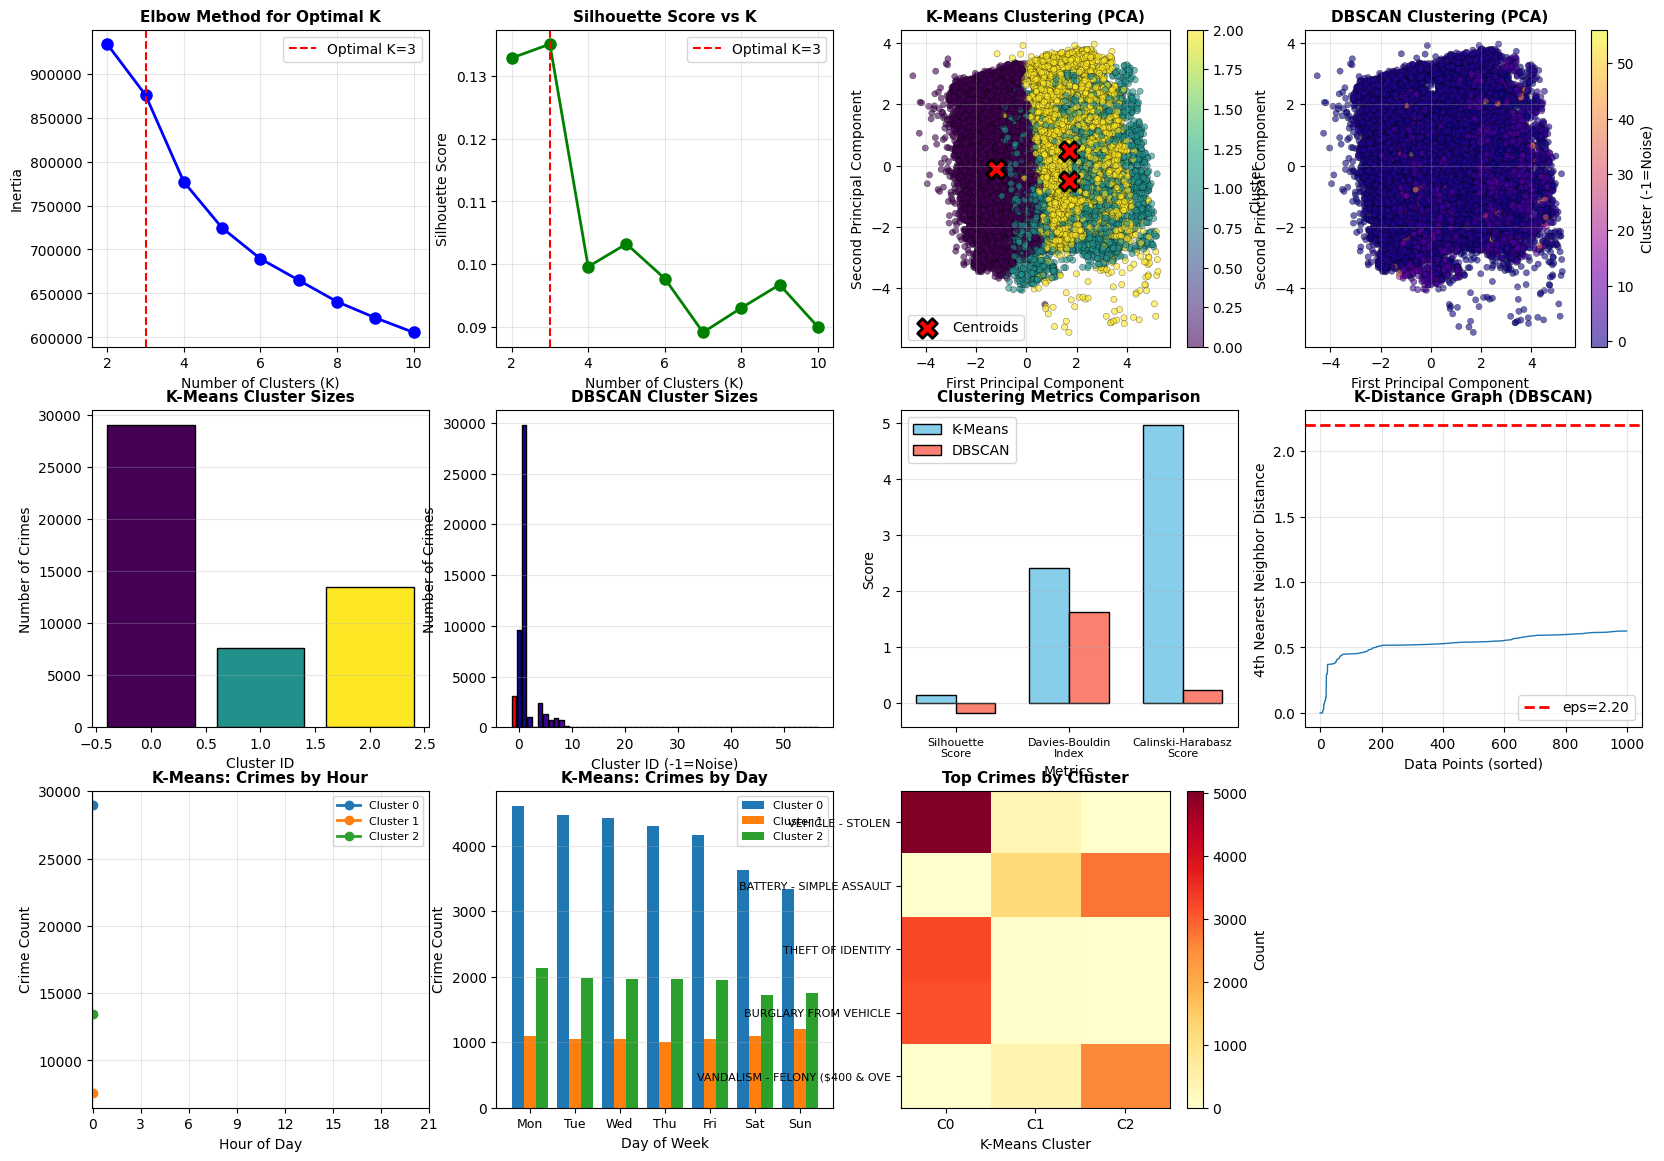

In [ ]:
# COMPREHENSIVE VISUALIZATIONS
# ============================================================================
print("\n" + "="*80)
print("GENERATING VISUALIZATIONS")
print("="*80)

fig = plt.figure(figsize=(20, 14))

# 1. Elbow Method for K-Means
ax1 = plt.subplot(3, 4, 1)
plt.plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (K)', fontsize=10)
plt.ylabel('Inertia', fontsize=10)
plt.title('Elbow Method for Optimal K', fontsize=11, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.axvline(x=optimal_k, color='r', linestyle='--', label=f'Optimal K={optimal_k}')
plt.legend()

# 2. Silhouette Scores
ax2 = plt.subplot(3, 4, 2)
plt.plot(K_range, silhouette_scores, 'go-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (K)', fontsize=10)
plt.ylabel('Silhouette Score', fontsize=10)
plt.title('Silhouette Score vs K', fontsize=11, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.axvline(x=optimal_k, color='r', linestyle='--', label=f'Optimal K={optimal_k}')
plt.legend()

# 3. K-Means Clustering Visualization (PCA)
ax3 = plt.subplot(3, 4, 3)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels,
                     cmap='viridis', alpha=0.6, s=20, edgecolors='k', linewidth=0.3)
centers_pca = pca.transform(kmeans.cluster_centers_)
plt.scatter(centers_pca[:, 0], centers_pca[:, 1],
           c='red', marker='X', s=200, edgecolors='black', linewidth=2, label='Centroids')
plt.xlabel('First Principal Component', fontsize=10)
plt.ylabel('Second Principal Component', fontsize=10)
plt.title('K-Means Clustering (PCA)', fontsize=11, fontweight='bold')
plt.colorbar(scatter, label='Cluster')
plt.legend()
plt.grid(True, alpha=0.3)

# 4. DBSCAN Clustering Visualization (PCA)
ax4 = plt.subplot(3, 4, 4)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=dbscan_labels,
                     cmap='plasma', alpha=0.6, s=20, edgecolors='k', linewidth=0.3)
plt.xlabel('First Principal Component', fontsize=10)
plt.ylabel('Second Principal Component', fontsize=10)
plt.title('DBSCAN Clustering (PCA)', fontsize=11, fontweight='bold')
plt.colorbar(scatter, label='Cluster (-1=Noise)')
plt.grid(True, alpha=0.3)

# 5. K-Means Cluster Size Distribution
ax5 = plt.subplot(3, 4, 5)
colors_km = plt.cm.viridis(np.linspace(0, 1, len(counts_kmeans)))
plt.bar(unique_kmeans, counts_kmeans, color=colors_km, edgecolor='black')
plt.xlabel('Cluster ID', fontsize=10)
plt.ylabel('Number of Crimes', fontsize=10)
plt.title('K-Means Cluster Sizes', fontsize=11, fontweight='bold')
plt.grid(axis='y', alpha=0.3)

# 6. DBSCAN Cluster Size Distribution
ax6 = plt.subplot(3, 4, 6)
colors_db = ['red' if c == -1 else plt.cm.plasma(c/max(unique_dbscan)) for c in unique_dbscan]
plt.bar(unique_dbscan, counts_dbscan, color=colors_db, edgecolor='black')
plt.xlabel('Cluster ID (-1=Noise)', fontsize=10)
plt.ylabel('Number of Crimes', fontsize=10)
plt.title('DBSCAN Cluster Sizes', fontsize=11, fontweight='bold')
plt.grid(axis='y', alpha=0.3)

# 7. Metrics Comparison
ax7 = plt.subplot(3, 4, 7)
metrics = ['Silhouette\nScore', 'Davies-Bouldin\nIndex', 'Calinski-Harabasz\nScore']
kmeans_vals = [kmeans_silhouette, kmeans_db, kmeans_ch/1000]  # Scale CH for visibility
dbscan_vals = [dbscan_silhouette if not np.isnan(dbscan_silhouette) else 0,
               dbscan_db if not np.isnan(dbscan_db) else 0,
               dbscan_ch/1000 if not np.isnan(dbscan_ch) else 0]

x = np.arange(len(metrics))
width = 0.35
plt.bar(x - width/2, kmeans_vals, width, label='K-Means', color='skyblue', edgecolor='black')
plt.bar(x + width/2, dbscan_vals, width, label='DBSCAN', color='salmon', edgecolor='black')
plt.xlabel('Metrics', fontsize=10)
plt.ylabel('Score', fontsize=10)
plt.title('Clustering Metrics Comparison', fontsize=11, fontweight='bold')
plt.xticks(x, metrics, fontsize=8)
plt.legend()
plt.grid(axis='y', alpha=0.3)

# 8. K-Distance Graph for DBSCAN
ax8 = plt.subplot(3, 4, 8)
plt.plot(distances[:1000], linewidth=1)  # Plot first 1000 for clarity
plt.axhline(y=eps_optimal, color='r', linestyle='--', linewidth=2, label=f'eps={eps_optimal:.2f}')
plt.xlabel('Data Points (sorted)', fontsize=10)
plt.ylabel('4th Nearest Neighbor Distance', fontsize=10)
plt.title('K-Distance Graph (DBSCAN)', fontsize=11, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# 9. Temporal patterns by K-Means cluster
ax9 = plt.subplot(3, 4, 9)
if 'hour' in df_sample.columns:
    for cluster in range(optimal_k):
        cluster_hours = df_sample[df_sample['KMeans_Cluster'] == cluster]['hour']
        hourly_counts = cluster_hours.value_counts().sort_index()
        plt.plot(hourly_counts.index, hourly_counts.values, marker='o', label=f'Cluster {cluster}', linewidth=2)
    plt.xlabel('Hour of Day', fontsize=10)
    plt.ylabel('Crime Count', fontsize=10)
    plt.title('K-Means: Crimes by Hour', fontsize=11, fontweight='bold')
    plt.legend(fontsize=8)
    plt.grid(True, alpha=0.3)
    plt.xticks(range(0, 24, 3))
else:
    plt.text(0.5, 0.5, 'No temporal data', ha='center', va='center', fontsize=12)
    plt.axis('off')

# 10. Day of week patterns by K-Means
ax10 = plt.subplot(3, 4, 10)
if 'dayofweek' in df_sample.columns:
    days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    cluster_day_data = []
    for cluster in range(optimal_k):
        cluster_days = df_sample[df_sample['KMeans_Cluster'] == cluster]['dayofweek'].value_counts().sort_index()
        cluster_day_data.append(cluster_days.values)

    x = np.arange(7)
    width = 0.8 / optimal_k
    for i, data in enumerate(cluster_day_data):
        plt.bar(x + i*width, data, width, label=f'Cluster {i}')

    plt.xlabel('Day of Week', fontsize=10)
    plt.ylabel('Crime Count', fontsize=10)
    plt.title('K-Means: Crimes by Day', fontsize=11, fontweight='bold')
    plt.xticks(x + width*(optimal_k-1)/2, days, fontsize=9)
    plt.legend(fontsize=8)
    plt.grid(axis='y', alpha=0.3)
else:
    plt.text(0.5, 0.5, 'No day data', ha='center', va='center', fontsize=12)
    plt.axis('off')

# 11. Crime type distribution by cluster (K-Means)
ax11 = plt.subplot(3, 4, 11)
if 'Crm Cd Desc' in df_sample.columns:
    top_crimes = df_sample['Crm Cd Desc'].value_counts().head(5).index
    crime_cluster_matrix = []
    for cluster in range(optimal_k):
        cluster_data = df_sample[df_sample['KMeans_Cluster'] == cluster]
        crime_counts = [len(cluster_data[cluster_data['Crm Cd Desc'] == crime]) for crime in top_crimes]
        crime_cluster_matrix.append(crime_counts)

    crime_cluster_matrix = np.array(crime_cluster_matrix).T
    im = plt.imshow(crime_cluster_matrix, cmap='YlOrRd', aspect='auto')
    plt.colorbar(im, label='Count')
    plt.yticks(range(len(top_crimes)), [c[:30] for c in top_crimes], fontsize=8)
    plt.xticks(range(optimal_k), [f'C{i}' for i in range(optimal_k)])
    plt.xlabel('K-Means Cluster', fontsize=10)
    plt.title('Top Crimes by Cluster', fontsize=11, fontweight='bold')
else:
    plt.text(0.5, 0.5, 'No crime type data', ha='center', va='center', fontsize=12)
    plt.axis('off')

# 12. Summary Statistics Table
ax12 = plt.subplot(3, 4, 12)
ax12.axis('off')
summary_data = [
    ['Metric', 'K-Means', 'DBSCAN'],
    ['Clusters', f'{optimal_k}', f'{n_clusters_dbscan}'],
    ['Silhouette', f'{kmeans_silhouette:.3f}', f'{dbscan_silhouette:.3f}' if not np.isnan(dbscan_silhouette) else 'N/A'],
    ['Davies-Bouldin', f'{kmeans_db:.3f}', f'{dbscan_db:.3f}' if not np.isnan(dbscan_db) else 'N/A'],
    ['Noise Points', '0', f'{n_noise}'],
    ['', '', ''],
    ['WINNER:', '', '']
]




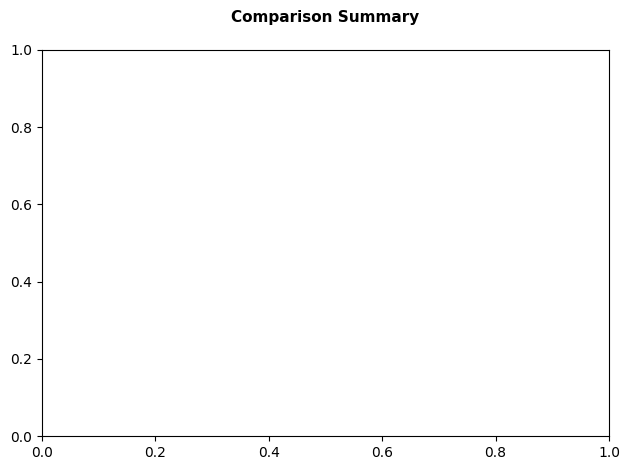

In [ ]:
# Determine winner
if not np.isnan(dbscan_silhouette):
    if kmeans_silhouette > dbscan_silhouette:
        summary_data[-1][1] = '✓'
    else:
        summary_data[-1][2] = '✓'

table = ax12.table(cellText=summary_data, cellLoc='center', loc='center',
                   colWidths=[0.4, 0.3, 0.3])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)

# Color header row
for i in range(3):
    table[(0, i)].set_facecolor('#4CAF50')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Color winner row
table[(6, 0)].set_text_props(weight='bold')
table[(6, 1)].set_facecolor('#FFD700')
table[(6, 2)].set_facecolor('#FFD700')

plt.title('Comparison Summary', fontsize=11, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()
